# 必要なライブラリをインストール
gqlを使って、GraphQLのQueryを発行する。
参考：https://takemikami.com/2021/02/04/GitHubAPIREST-API-GraphQL-APIPython.html

In [8]:
from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

## 取得するブロックの範囲を定義


In [25]:
# London Update 12,965,000
start = 13452000
end =   13457600
step = 1000

# gas priceの計算関数を定義

## GraphQLのQueryを定義

In [26]:
query = """query GetBlocks($start: Long!, $end: Long!) {
      blocks(from: $start, to: $end) {
        number,
        baseFeePerGas,
        transactions {
          gas,
          gasUsed,
          gasPrice,
          maxFeePerGas,
          maxPriorityFeePerGas,
        }
      }
    }"""

# baseFeesをgwei単位に変換するために定義
gwei_unit = 1000000000


## go-ethereumからデータを取得

In [27]:
client = Client(
    transport=RequestsHTTPTransport(
      url = "http://localhost:8545/graphql",
      use_json = True,
      headers = {
        "Content-type": "application/json",
        "Content-Length": str(len(query))
      },
      retries = 3,
    ),
    fetch_schema_from_transport=True,
)

blocks = []
for bfrom in np.arange(start, end, step):
    bto = bfrom+step
    print(f"start={bfrom}, end={bto}")
    
    if bto > end:
        bto = end
    variable = {"start": str(bfrom+1), "end": str(bto)}
    resp = client.execute(
      gql(query),
      variable_values = variable)
    blocks.extend(resp["blocks"])
    print(f"{variable} load end. blocks.len={len(blocks)}")

print(len(blocks))
print("load OK")

start=13452000, end=13453000
{'start': '13452001', 'end': '13453000'} load end. blocks.len=1000
start=13453000, end=13454000
{'start': '13453001', 'end': '13454000'} load end. blocks.len=2000
start=13454000, end=13455000
{'start': '13454001', 'end': '13455000'} load end. blocks.len=3000
start=13455000, end=13456000
{'start': '13455001', 'end': '13456000'} load end. blocks.len=4000
start=13456000, end=13457000
{'start': '13456001', 'end': '13457000'} load end. blocks.len=5000
start=13457000, end=13458000
{'start': '13457001', 'end': '13457600'} load end. blocks.len=5600
5600
load OK


## 取得したデータをグラフにplot

          baseFees  prioritys  gasPrices
1110661  74.069206   2.500000  76.569206
1110662  74.069206   2.120000  76.189206
1110663  74.069206   2.000000  76.069206
1110664  74.069206   2.000000  76.069206
1110665  74.069206   2.000000  76.069206
...            ...        ...        ...
1120656  75.196654  76.242558  76.242558
1120657  75.196654   1.000000  76.196654
1120658  75.196654   1.000000  76.196654
1120659  75.196654   1.000000  76.196654
1120660  75.196654   1.000000  76.196654

[10000 rows x 3 columns]
1120661


<AxesSubplot:title={'center':'get txfees last 300 in blocks $13452000 ~ $13457600'}>

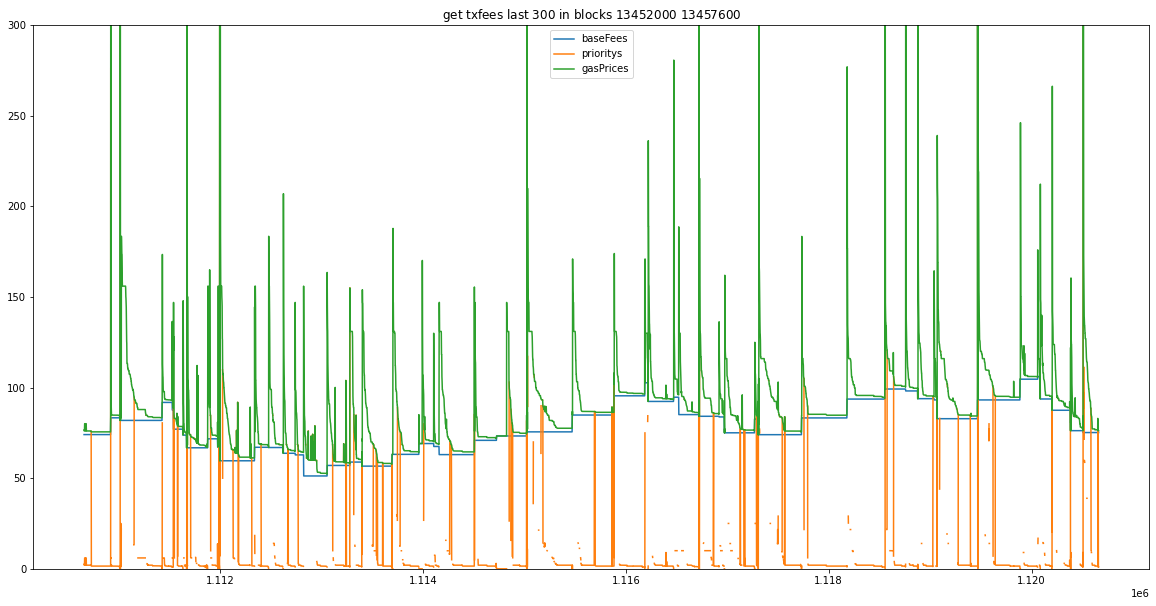

In [31]:
def gasFee(baseFee, tx):
    gasUsed = tx['gasUsed']
    gasPrice = int(tx['gasPrice'], base=16)
    maxFee = None
    priority = None
    
    fee = gasPrice * gasUsed / gwei_unit
    if(tx['maxFeePerGas']):
        maxFee = int(tx['maxFeePerGas'], base=16)
        priority = int(tx['maxPriorityFeePerGas'], base=16)
        price = priority + baseFee
        if price > maxFee:
            price = maxFee
        
        fee = gasUsed * price / gwei_unit
        maxFee = maxFee /gwei_unit
        priority = priority / gwei_unit

#     print f"fee={fee}, gasUsed={gasUsed}, gasPrice={gasPrice / gwei_unit}, maxFee={maxFee}, priority={priority}, baseFee={baseFee / gwei_unit}"
    return {
        "fee": fee,
        "gasUsed": gasUsed,
        "gasPrice": gasPrice / gwei_unit,
        "maxFee": maxFee,
        "priority": priority,
        "baseFee": baseFee / gwei_unit }
#     } if(maxFee and priority != (gasPrice / gwei_unit)) else None


baseFees = list()
maxFees = list()
prioritys = list()
useds = list()
prices = list()
for block in blocks:
    baseFee = int(block["baseFeePerGas"] if(block["baseFeePerGas"]) else "0", base=16)
    for tx in block['transactions']:
        gasInfo = gasFee(baseFee, tx)
        
        if(gasInfo):
            baseFees.append(gasInfo['baseFee'])
            maxFees.append(gasInfo['maxFee'])
            prioritys.append(gasInfo['priority'])
            useds.append(gasInfo['gasUsed'])
            prices.append(gasInfo['gasPrice'])
    
df = pd.DataFrame({
    "baseFees": baseFees,
#     "maxFees": maxFees,
    "prioritys": prioritys,
#     'gasUsed': useds,
    "gasPrices": prices
})

print(df[len(df)-10000:])
print(len(df))
df[len(df)-10000:].plot(secondary_y=["gasUsed"], title=f"get txfees last 300 in blocks ${start} ~ ${end}", figsize=(20,10), ylim=(0, 300))

In [20]:
import json;

def items_str(dflist):
    return list(map(lambda x: f'{x}', dflist))
    
datasets = []
dataset = {'labels': list(df.index)}

for col in df.columns:
    dataset[col] = list(df[col])

with open("./work/pythonProject/eth_load/dataset.json", 'w') as f:
    f.write(str(dataset))

print("data save end.")


data save end.


        baseFees
57200  79.714749
57201  89.414433
57202  78.237629
57203  79.667073
57204  84.255364
...          ...
57595  93.720454
57596  87.494467
57597  87.125686
57598  76.234975
57599  75.196654

[400 rows x 1 columns]
57600


<AxesSubplot:title={'center':'get txfees last 300 in blocks $13400000 ~ $13457600'}>

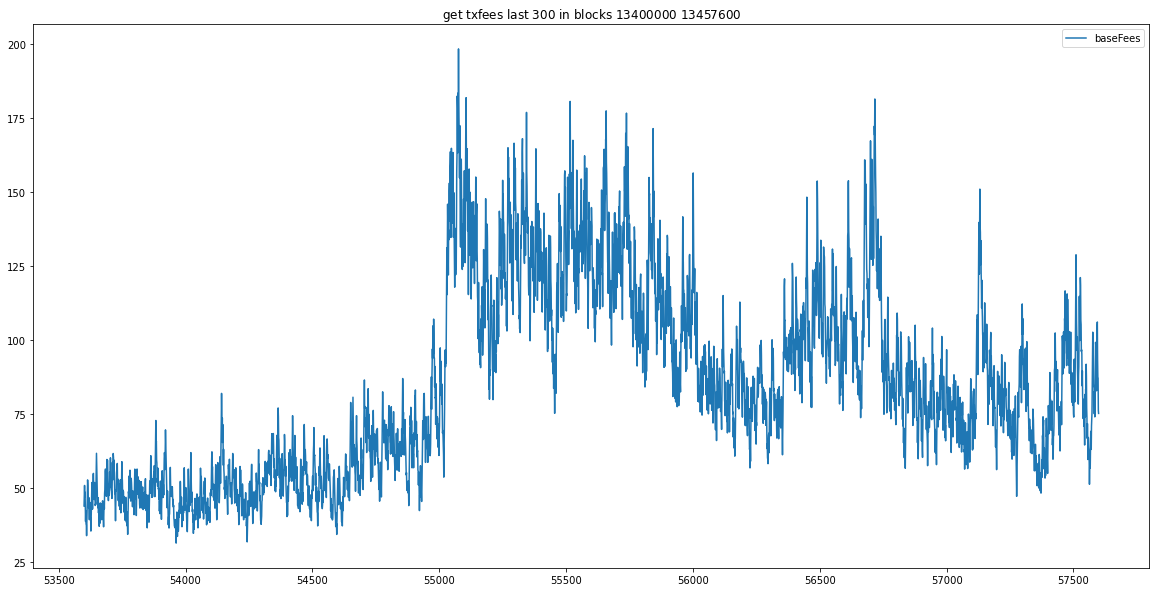

In [31]:
baseFees = list()
maxFees = list()
prioritys = list()
useds = list()
for block in blocks:
    baseFee = int(block["baseFeePerGas"] if(block["baseFeePerGas"]) else "0", base=16)
    baseFees.append(baseFee / 1000000000)
    
df = pd.DataFrame({
    "baseFees": baseFees
})

print(df[len(df)-400:])
print(len(df))
df[len(df)-4000:].plot(title=f"get txfees last 300 in blocks ${start} ~ ${end}", figsize=(20,10))